<a href="https://colab.research.google.com/github/ryanamundson1/gcolab/blob/master/bivariate_cloropleth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import geopandas
import geoplot
import os
import pandas
import requests
import fiona
import io
import tempfile
import zipfile

First import the shape files for the United States state data

In [55]:
data = requests.get("https://raw.githubusercontent.com/ryanamundson1/gcolab/master/shapes/gz_2010_us_040_00_5m.zip")
temp_dir = tempfile.TemporaryDirectory(suffix=".zip")

z = zipfile.ZipFile(io.BytesIO(data.content))

z.extractall(path=temp_dir.name) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 

country = geopandas.read_file(temp_dir.name + "/gz_2010_us_040_00_5m/gz_2010_us_040_00_5m.shp")
country.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,None,50645.326,"(POLYGON ((-88.124658 30.28364, -88.0868119999..."
1,0400000US02,02,Alaska,None,570640.950,"(POLYGON ((-166.10573981049 53.98860619480801,..."
2,0400000US04,04,Arizona,None,113594.084,"POLYGON ((-112.538593055121 37.0006737215344, ..."
3,0400000US05,05,Arkansas,None,52035.477,"POLYGON ((-94.042964 33.019219, -94.043036 33...."
4,0400000US06,06,California,None,155779.220,"(POLYGON ((-122.421438985378 37.8699688894578,..."


Now we can load data into dataframes to join against the state data. I'm using mortality rates from CDC's wonder site: https://wonder.cdc.gov/cmf-ICD10.html

In [59]:
mortality = pandas.read_csv("https://raw.githubusercontent.com/ryanamundson1/gcolab/master/data/gc/state_mortality.txt", sep='\t')
firearmdf = mortality[mortality['Cause of death'].str.contains("discharge")==True]
firearmdf['Rate'] = firearmdf['Crude Rate'].str.extract('(\d+[.]\d+)').astype(float)

#Get the mean mortality for each state 
staterate = firearmdf.groupby("State").mean().reset_index()
staterate.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,State,State Code,Deaths,Population,Crude Rate Standard Error,Rate
0,Alabama,1.0,310.555556,28496755.0,0.048889,1.090000
1,Alaska,2.0,124.400000,4664845.0,0.228000,2.668000
2,Arizona,4.0,372.111111,38661164.0,0.036667,0.962222
3,Arkansas,5.0,144.600000,17557789.0,0.052000,0.824000
4,California,6.0,1382.909091,234398139.0,0.010000,0.590000


Now get the gun law scores using this site. I'm coverting the grades into numerical data and inverting them for the cloropleth. The grades have been extracted from the Gun Law Scorecard: https://lawcenter.giffords.org/scorecard/

In [60]:
laws = pandas.read_csv("https://raw.githubusercontent.com/ryanamundson1/gcolab/master/data/gc/gun_law_scores.txt")
grades = [('A+', 4.0), ('A', 4.0), ('A-', 3.7), ('B+',3.3), ('B',3.0), ('B-',2.7), ('C+',2.3), ('C',2.0),
          ('C-',1.7),('D+',1.3),('D',1.0),('D-',0.7),('F',0.0)]

grades = dict(grades)
laws["number_grade"] = laws["grade"].apply(lambda x: 4 - grades.get(x))
laws.head()

,rank,state,grade,deaths,value,number_grade
0,1,California,A,44,7.8,0.0
1,2,New Jersey,A,45,5.3,0.0
2,3,Connecticut,A-,46,5.1,0.3
3,4,Maryland,A-,29,12.3,0.3
4,5,Massachusetts,A-,49,3.7,0.3


In [0]:
# merge the data into a DF
merged = country.merge(staterate, left_on='NAME', right_on='State', how='outer')
merged = merged[merged['NAME'].isin(['Alaska','Hawaii']) == False].fillna(0)

merged2 = country.merge(laws, left_on='NAME', right_on='state', how='outer')
merged2 = merged2[merged2['NAME'].isin(['Alaska','Hawaii']) == False].fillna(0)

Now let's make some charts, the states with low grades in gun control laws in blue, and the mortality rate for kids are in red

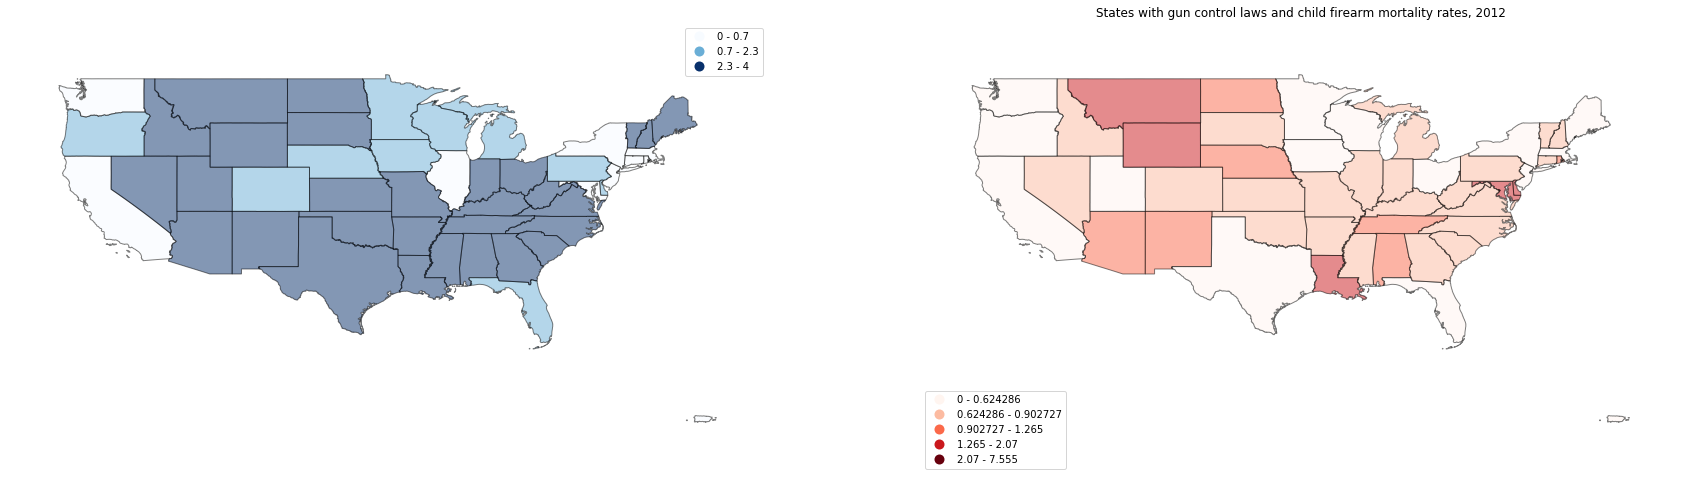

In [65]:
import matplotlib.pyplot as plt

#f, ax = plt.subplots(1)
fig = plt.figure(figsize=(30,20))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

plot1 = geoplot.choropleth(
    merged2, alpha=0.5, hue=merged2['number_grade'],
    cmap='Blues', figsize=(30, 20), legend=True, ax=ax1
)
plot2 = geoplot.choropleth(
    merged, alpha=0.5, hue=merged['Rate'],
    cmap='Reds', figsize=(30, 20), legend=True, scheme='fisher_jenks', ax=ax2
)
#plt.show()

plt.title("States with gun control laws and child firearm mortality rates, 2019")

plt.savefig("gc-laws-and-gun-mortality.png", bbox_inches='tight', pad_inches=0.1)